**Ex 1**

**1.1**

In [1]:
import networkx as nx
import numpy as np

In [2]:
G = nx.Graph()

text_path = "ca-AstroPh.txt"

with open(text_path, "r") as f:
    for line in f:
        n1, n2 = line.strip().split()

        if G.has_edge(n1, n2):
            G[n1][n2]["weight"] += 1
        else:
            G.add_edge(n1, n2, weight=1)

In [3]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 18772
Number of edges: 198110


In [4]:
for u, v, data in list(G.edges(data=True))[:5]:
    print(u, v, data)

84424 276 {'weight': 2}
84424 1662 {'weight': 2}
84424 5089 {'weight': 2}
84424 6058 {'weight': 2}
84424 6229 {'weight': 2}


**1.2**

In [5]:
def ego_features(G):
    N = {}
    E = {}
    W = {}
    lambdaw = {}
        
    for u in G.nodes():
        ego = nx.ego_graph(G, u, radius=1)
        
        N[u] = G.degree(u)
        E[u] = ego.number_of_edges()
        W[u] = sum(d["weight"] for _, _, d in ego.edges(data=True))
            
        if ego.number_of_nodes() > 1 and ego.number_of_edges() > 0:
            A = nx.to_numpy_array(ego, weight="weight")
            eigvals = np.linalg.eigvals(A)
            lambdaw[u] = float(np.max(np.real(eigvals)))
        else:
            lambdaw[u] = 0.0

    return N, E, W, lambdaw

In [6]:
N, E, W, lambdaw = ego_features(G)

In [7]:
nx.set_node_attributes(G, N, "N")
nx.set_node_attributes(G, E, "E")
nx.set_node_attributes(G, W, "W")
nx.set_node_attributes(G, lambdaw, "lambdaw")

**1.3**

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
def fit_logreg(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    X = np.log(x).reshape(-1, 1)
    Y = np.log(y)
    model = LinearRegression()
    model.fit(X, Y)
    theta = model.coef_[0]
    logC = model.intercept_
    C = np.exp(logC)
    return C, theta

In [10]:
N_vals = np.array([G.nodes[u]["N"] for u in G.nodes()])

E_vals = np.array([G.nodes[u]["E"] for u in G.nodes()])

In [11]:
C, theta = fit_logreg(N_vals, E_vals)

In [12]:
def comp_anomaly_scores(G, feat1, feat2, C, theta):
    scores = {}
    for u in G.nodes():
        x = G.nodes[u].get(feat1, 0)
        y_true = G.nodes[u].get(feat2, 0)
        if x > 0 and y_true > 0:
            y_pred = C * x ** theta
            ratio = max(y_true, y_pred) / min(y_true, y_pred)
            diff = np.log(abs(y_true - y_pred) + 1)
            scores[u] = ratio * diff
        else:
            scores[u] = 0.0
            
    return scores

In [13]:
scores = comp_anomaly_scores(G, "N", "E", C, theta)

In [14]:
nx.set_node_attributes(G, scores, "anomaly_score")

In [15]:
G = nx.Graph()

with open(text_path, "r") as f:
    for i, line in enumerate(f):
        if i >= 1500:
            break
        n1, n2 = line.strip().split()
        if G.has_edge(n1, n2):
            G[n1][n2]["weight"] += 1
        else:
            G.add_edge(n1, n2, weight=1)

In [16]:
N, E, _, _ = ego_features(G)

nx.set_node_attributes(G, N, "N")
nx.set_node_attributes(G, E, "E")

N_vals = np.array([N[u] for u in G.nodes()])
E_vals = np.array([E[u] for u in G.nodes()])

C, theta = fit_logreg(N_vals, E_vals)

scores = comp_anomaly_scores(G, "N", "E", C, theta)

In [17]:
nx.set_node_attributes(G, scores, "anomaly_score")

In [18]:
top_nodes = sorted(scores.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [u for u, s in top_nodes[:10]]

**1.4**

In [19]:
import matplotlib.pyplot as plt

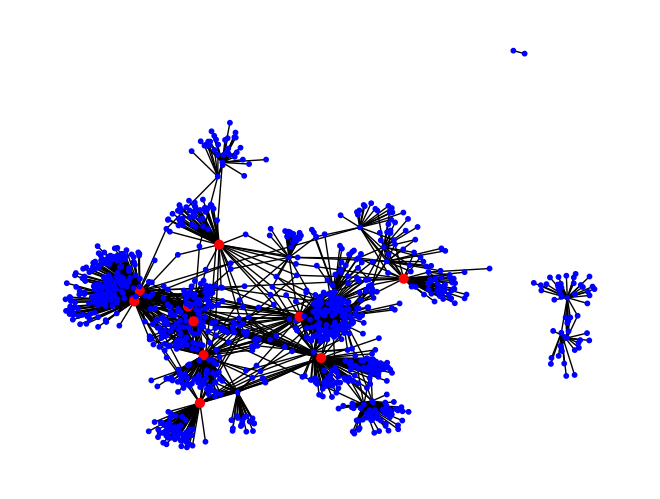

In [20]:
node_colors = ["red" if u in top_10_nodes else "blue" for u in G.nodes()]

node_sizes = [40 if u in top_10_nodes else 10 for u in G.nodes()]
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False)

In [21]:
top_10_nodes

['126916',
 '84424',
 '94138',
 '106274',
 '127393',
 '75607',
 '13353',
 '60471',
 '35690',
 '30625']

**1.5**

In [22]:
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler

In [23]:
nodes = list(G.nodes())
X_lof = np.array([[N[u], E[u]] for u in nodes])

In [24]:
lof = LOF(n_neighbors = 20)
lof.fit(X_lof)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [25]:
lof_scores = lof.decision_scores_

In [26]:
scaler = MinMaxScaler()

power_scores = np.array([scores[u] for u in nodes]).reshape(-1, 1)
power_scores_norm = scaler.fit_transform(power_scores).flatten()

lof_scores_norm = scaler.fit_transform(lof_scores.reshape(-1, 1)).flatten()

In [27]:
final_scores = power_scores_norm + lof_scores_norm

final_scores_dict = {
    u: final_scores[i] for i, u in enumerate(nodes)
}

In [28]:
nx.set_node_attributes(G, final_scores_dict, "combined_score")

In [29]:
top_10_nodes = sorted(final_scores_dict, key=final_scores_dict.get, reverse=True)[:10]

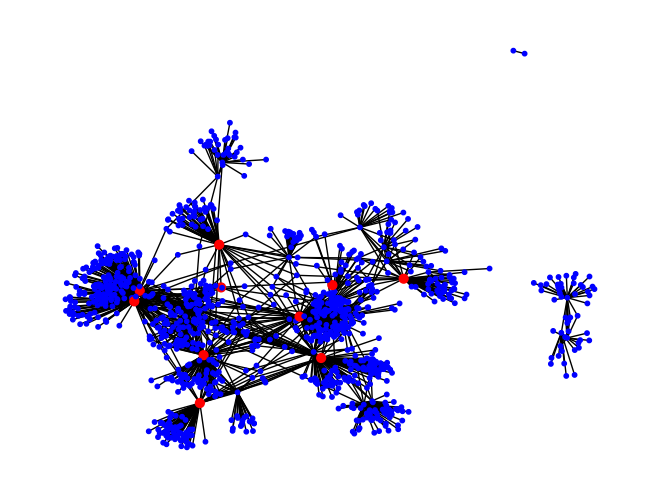

In [30]:
node_colors = ["red" if u in top_10_nodes else "blue" for u in G.nodes()]

node_sizes = [40 if u in top_10_nodes else 10 for u in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False)

**Ex. 2**

In [31]:
G_regular = nx.random_regular_graph(d=3, n=100)

In [32]:
G_cliques = nx.connected_caveman_graph(l=10, k=20)

In [33]:
G = nx.union(G_regular, G_cliques, rename=("R_", "C_"))

In [34]:
nodes = list(G.nodes())

for _ in range(20):
    u, v = np.random.choice(nodes, 2, replace=False)
    G.add_edge(u, v)

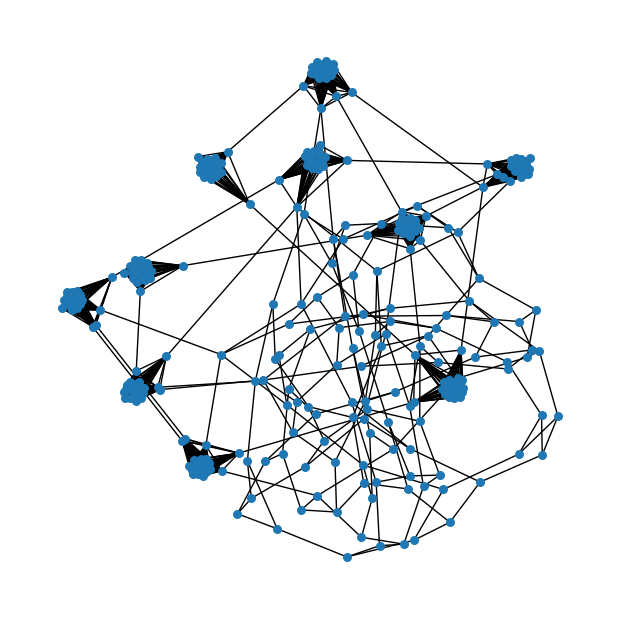

In [35]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_size=30, with_labels=False)
plt.show()

In [36]:
N = {}
E = {}

for u in G.nodes():
    ego = nx.ego_graph(G, u, radius=1)
    N[u] = G.degree(u)
    E[u] = ego.number_of_edges()

nx.set_node_attributes(G, N, "N")
nx.set_node_attributes(G, E, "E")

In [37]:
N_vals = np.array([N[u] for u in G.nodes()])
E_vals = np.array([E[u] for u in G.nodes()])

C, theta = fit_logreg(N_vals, E_vals)

scores = comp_anomaly_scores(G, "N", "E", C, theta)

In [38]:
top_10_nodes = sorted(scores, key=scores.get, reverse=True)[:10]

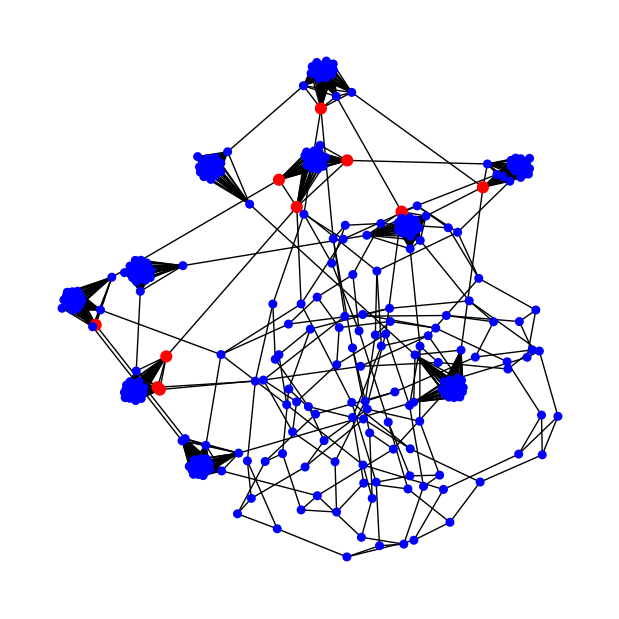

In [39]:
node_colors = ["red" if u in top_10_nodes else "blue" for u in G.nodes()]
node_sizes = [60 if u in top_10_nodes else 30 for u in G.nodes()]

plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False)
plt.show()

**2.2**

In [40]:
G3 = nx.random_regular_graph(d=3, n=100)
G5 = nx.random_regular_graph(d=5, n=100)

In [41]:
G = nx.union(G3, G5, rename=("R3_", "R5_"))

In [42]:
#we add some random edges to make the graph connected

nodes_R3 = [n for n in G.nodes() if n.startswith("R3_")]
nodes_R5 = [n for n in G.nodes() if n.startswith("R5_")]

for _ in range(5):
    u = np.random.choice(nodes_R3)
    v = np.random.choice(nodes_R5)
    G.add_edge(u, v, weight=1)

In [43]:
for u, v in G.edges():
    G[u][v]["weight"] = 1

In [44]:
np.random.seed(42)
heavy_nodes = np.random.choice(list(G.nodes()), 2, replace=False)

In [45]:
for u in heavy_nodes:
    ego = nx.ego_graph(G, u, radius=1)
    for x, y in ego.edges():
        G[x][y]["weight"] += 10

In [46]:
_, E, W, _ = ego_features(G)

nx.set_node_attributes(G, E, "E")
nx.set_node_attributes(G, W, "W")

In [47]:
E_vals = np.array([E[u] for u in G.nodes()])
W_vals = np.array([W[u] for u in G.nodes()])

C, theta = fit_logreg(E_vals, W_vals)

scores = comp_anomaly_scores(G, "E", "W", C, theta)

In [48]:
top_4_nodes = sorted(scores, key=scores.get, reverse=True)[:4]

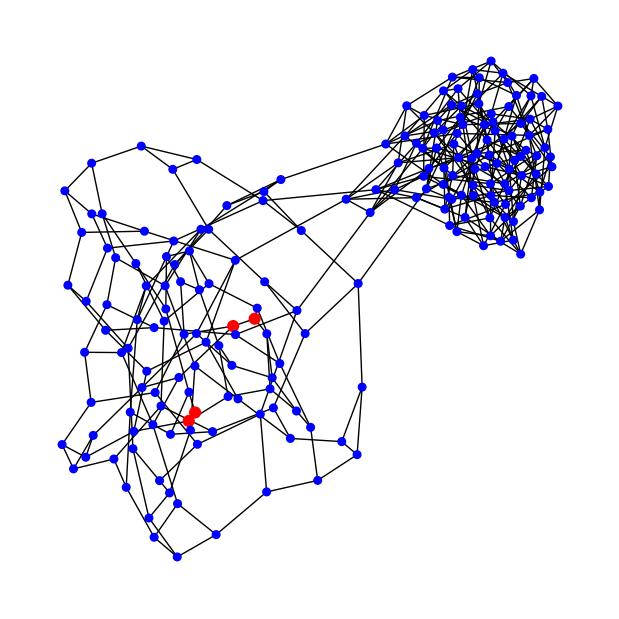

In [49]:
pos = nx.spring_layout(G, seed=42)

node_colors = ["red" if u in top_4_nodes else "blue" for u in G.nodes()]
node_sizes = [60 if u in top_4_nodes else 30 for u in G.nodes()]

plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False)
plt.show()

**Ex. 3**

**3.1 & 3.2**

In [50]:
from scipy.io import loadmat

data = loadmat("ACM.mat")

In [51]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Network', 'Label', 'Attributes', 'Class'])

In [52]:
attr = data["Attributes"]
adj_matrix = data["Network"]
labels = data["Label"]

In [53]:
from torch_geometric.utils import from_scipy_sparse_matrix

edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)

**3.3**

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [55]:
class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        z = F.relu(self.conv2(x, edge_index))
        return z

In [56]:
class AttributeDecoder(nn.Module):
    def __init__(self, latent_dim=64, hidden=128, output_dim=None):
        super(AttributeDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden)
        self.conv2 = GCNConv(hidden, output_dim)

    def forward(self, z, edge_index):
        x_hat = F.relu(self.conv1(z, edge_index))
        x_hat = self.conv2(x_hat, edge_index)
        return x_hat

In [57]:
class StructureDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(StructureDecoder, self).__init__()
        self.conv = GCNConv(latent_dim, latent_dim)

    def forward(self, z, edge_index):
        z_out = F.relu(self.conv(z, edge_index))
        adj_hat = torch.matmul(z_out, z_out.t())
        return adj_hat

In [58]:
class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GCNEncoder(input_dim, hidden1, hidden2)
        self.attr_decoder = AttributeDecoder(latent_dim=hidden2, hidden=hidden1, output_dim=input_dim)
        self.struct_decoder = StructureDecoder(latent_dim=hidden2)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_hat = self.attr_decoder(z, edge_index)
        adj_hat = self.struct_decoder(z, edge_index)
        return x_hat, adj_hat, z

**3.4**

In [59]:
def custom_loss(X, X_hat, A, A_hat, alpha=0.8):
    attr_loss = torch.norm(X - X_hat, p='fro')**2
    struct_loss = torch.norm(A - A_hat, p='fro')**2
    loss = alpha * attr_loss + (1 - alpha) * struct_loss
    return loss

**3.5**

In [60]:
from sklearn.metrics import roc_auc_score

In [61]:
num_nodes = adj_matrix.shape[0]
A_dense = torch.zeros(num_nodes, num_nodes)

for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    dst = edge_index[1, i].item()
    A_dense[src, dst] = 1

In [62]:
attr_dense = attr.toarray()
x = torch.tensor(attr_dense, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)

In [63]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

In [64]:
input_dim = x.size(1)
model = GraphAutoencoder(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
alpha = 0.8
epochs = 50

In [65]:
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    
    X_hat, A_hat, Z = model(x, edge_index)
    loss = custom_loss(x, X_hat, A_dense, A_hat, alpha)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            X_hat, A_hat, _ = model(x, edge_index)
            attr_error = torch.norm(x - X_hat, p=2, dim=1)
            struct_error = torch.norm(A_dense - A_hat, p=2, dim=1)
            scores = alpha * attr_error + (1 - alpha) * struct_error
            auc = roc_auc_score(y.numpy(), scores.numpy())
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, ROC AUC: {auc:.4f}")

Epoch 5, Loss: 40019.2930, ROC AUC: 0.8953
Epoch 10, Loss: 39565.2188, ROC AUC: 0.8945
Epoch 15, Loss: 39758.4492, ROC AUC: 0.8947
Epoch 20, Loss: 39602.3672, ROC AUC: 0.8947
Epoch 25, Loss: 39684.4805, ROC AUC: 0.8946
Epoch 30, Loss: 39626.0078, ROC AUC: 0.8947
Epoch 35, Loss: 39625.4883, ROC AUC: 0.8946
Epoch 40, Loss: 39562.1523, ROC AUC: 0.8947
Epoch 45, Loss: 39525.6133, ROC AUC: 0.8948
Epoch 50, Loss: 39431.0156, ROC AUC: 0.8948
